# Structured bonds pricing

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import datetime as datetime
from dateutil.relativedelta import relativedelta
from plotly.subplots import make_subplots
import plotly.graph_objects as pltgo
import matplotlib.pyplot as plt
from scipy.stats import norm

# Importing local libraries
from FinDates.daycount import yearfrac
from FinDates.busdayrule import rolldate
import FinDates.holidays as holidays


In [2]:
# Import dicount factor curve obtained from the bootstrap lab
discountFactor = pd.read_csv('discountFactor.csv'
                            , names = ['date', 'discount_Factor']
                            , skiprows = 1
                            )
discountFactor.head()

# Import zero rate curve obtained from the bootstrap lab
zeroRates   = pd.read_csv('zeroRates.csv'
                            , names = ['date', 'zero_Rate']
                            , skiprows = 1
                            )
zeroRates['date'] = pd.to_datetime(zeroRates['date'])
zeroRates.set_index('date', inplace=True)
zeroRates.head()

,zero_Rate
date,
2008-02-20,0.040655
2008-02-26,0.041249
2008-03-19,0.042057
2008-06-19,0.043181
2008-09-18,0.041651


##  Pricing of SWAP termsheet

To price the intrument we will find price the the coupons paid between the parties A (Bank XX) and B (IB). Then the flows from each party should be the same value so ther is no arbitrage. The difference between the flows of each party is the upfront payment (X).

First we interpolate linearly the zero rate curve for everyday obtaining the new curve called 'zeroRates_interp'

In [3]:
# The Zero rate curve is interpolated for each day between the first and lat monitoring date

## Generate a daily date range between the first and last date
date_range = pd.date_range(start=zeroRates.index.min(), end=zeroRates.index.max(), freq='D')

## Linear interpolation of the Zero Rates
zeroRates_interp = zeroRates.reindex(date_range).interpolate(method='linear')

print(zeroRates_interp)

            zero_Rate
2008-02-20   0.040655
2008-02-21   0.040754
2008-02-22   0.040853
2008-02-23   0.040952
2008-02-24   0.041051
...               ...
2058-02-15   0.044686
2058-02-16   0.044686
2058-02-17   0.044685
2058-02-18   0.044685
2058-02-19   0.044685

[18263 rows x 1 columns]


### 1. Zero-rate Bond Pricing
The price of a zero-coupon bond of maturity T at any instant t < T will be denoted by $ B( t , T )$. Given the yield-to-maturity process $Y(t, T )$ , the corresponding bond price process $B(t, T )$ is uniquely determined by the formula:
$$
B( t , T ) = e^{-Y(t,T)(T-t)}
$$

In [4]:
# Bond characteristics
bond_issue  = 100 #MMEURO
trade_date  = datetime.date(2008, 2, 15)
start_date  = datetime.date(2008, 2, 19)
maturity_Y  = 4

_calendar   = holidays.get_calendar('de')
maturity_date = start_date + relativedelta(years=maturity_Y)
maturity_date = rolldate(maturity_date, _calendar, 'follow')

# Get the zero rate of the bond for the maturity date
bond_idx    = zeroRates_interp.index.get_loc(maturity_date) 
zero_Bond   = zeroRates_interp.iloc[bond_idx]['zero_Rate']

# Convert zero rate to Discount factor
daycount_Bond = 'ACT/360'
yearFrac_Bond = yearfrac(start_date, maturity_date, daycount_Bond)
B_Bond = np.exp(-zero_Bond * yearFrac_Bond)

# Price of the bond in MMEUR
p_Bond = B_Bond * bond_issue

print(p_Bond)

85.41445023797401


### 2. Pricing of EURIBOR coupons
We calculate the forward Euribor rate and add the SPOL of 200 basis points (bps) to find the floaters for each coupon paid. Then we calculate the NPV of the coupons by dicounting the EURIBOR rates multiplied by the bond face value. The Euribor forward rate is calcualted using the following formula, where $\delta = 1/4$ :
$$
L(t,T) = F(t, T, T + \delta) = \frac{1}{\delta} \left( \frac{B(t, T) - B(t, T + \delta)}{B(t, T + \delta)} \right)
$$

In [5]:
# Coupon characteristics
SPOL    = 200       #bps
coupons = maturity_Y * 4
delta_c = 1/4
t_coupon= 360/4
daycount_Coupon = 'ACT/360'


# Calculate the coupon dates by considering that each coupon will be paid plus 3 months
payment_dates = []
payment_date = start_date

for i in range(coupons):
    if  payment_date < maturity_date.date():
        payment_date = payment_date + relativedelta(months = 3)
    else:
        payment_date = maturity_date

    coupon_i    =   rolldate(payment_date, _calendar, 'follow')
    payment_dates.append(coupon_i)

In [6]:
# Getting the Euribor forward + SPOL
def get_Euribor_forward(zeroRates_interp, start_date, payment_dates, SPOL, bond_issue, daycount_Coupon):
    coupon_NPV    = []
    for i in range(coupons):
        T           = payment_dates[i]
        T_delta     = T + relativedelta(months = 3)
        zid_T       = zeroRates_interp.index.get_loc(T)
        zid_T_delta = zeroRates_interp.index.get_loc(T_delta)
        
        # Discount at time T
        zRate_T     = zeroRates_interp.iloc[zid_T]['zero_Rate']
        yFrac_T     = yearfrac(start_date, T, daycount_Coupon)
        B_z         = np.exp(-zRate_T*yFrac_T)

        # Discount at time T+delta
        zRate_T_delta= zeroRates_interp.iloc[zid_T_delta]['zero_Rate']
        yFrac_T_delta= yearfrac(start_date, T_delta, daycount_Coupon)
        B_z_delta   = np.exp(-zRate_T_delta*yFrac_T_delta)

        # Euribor interest
        Euribor_i   = 1/delta_c*(B_z-B_z_delta)/B_z_delta

        # Cash flow
        coupon_NPVi = 1*(Euribor_i+SPOL/10000)*B_z*delta_c
        coupon_NPV.append(coupon_NPVi)

        #print('date T', T, 't+delta', T_delta)

    p_coupon = sum(coupon_NPV)*bond_issue
    return p_coupon

In [7]:
p_coupon = get_Euribor_forward(zeroRates_interp, start_date, payment_dates, SPOL, bond_issue, daycount_Coupon)
print("The total amount of the coupons at present paid by the bank XX ", f'{p_coupon:.2f}' , "MIO EUR")

The total amount of the coupons at present paid by the bank XX  21.93 MIO EUR


### 3. Pricing of Asian option
The coupon is paid yearly after evaluating the average performance of the underlying (ENEL Stock). To check the underlying spot price we simulate differents paths of the underlying and calculate the average.

#### 3.1 Simulation of path
The SDE that describes the dynamics of an asset price $S_{(t)}$ under the risk-neutral measure, considering the time-varying risk-free rate $r_{(u)}$, and assuming the asset pays a continuous dividend yield of $\gamma$ is:
$$
\frac{dS_{(t)}}{S_{(t)}}=\mu_{(t)}dt + \sigma dW_{(t)}, \ where \ \mu=r_{(t)}-\gamma
$$
The solution to the SDE is:
$$
S(t) = S(0) exp \Bigg(\int^{t}_{0}r(u)du - \Big(\gamma + \frac{1}{2}\sigma^2 \Big)t + \sigma W_{i+1} \Bigg)
$$
And can be simulated by:
$$
S(t_{i+1}) = S(t_{i}) exp \Bigg(\int^{t_{i+1}}_{t_{i}}r(u)du - \Big(\gamma + \frac{1}{2}\sigma^2 \Big)(t_{i+1}-t_{i}) + \sigma\sqrt{t_{i+1}-t_{i}} Z_{i+1} \Bigg)
$$
With $Z_1, ..., Z_i$ as independent normal random variables

To discretize the integral we aproximate the value to:
$$
\int^{t_{i+1}}_{t_{i}}r(u)du \approx r(u) (t_{i+1} -t_{i})
$$

In [8]:
# We calculate the yearly monitoring dates considering the following business day convention
monitoring_date_0 = datetime.date(2008, 2, 15)
asian_coupons   = maturity_Y

monitoring_dates= []
monitoring_date = monitoring_date_0 #Initializing the variable

for i in range(asian_coupons):
    monitoring_date = monitoring_date + relativedelta(years = 1)
    monitoring_i    =   rolldate(monitoring_date, _calendar, 'follow')
    monitoring_dates.append(monitoring_i)

In [9]:
# Define the function to calculate the path of the underlying

# Function definition of Asian option pricing
def exp_paths(seed, y_div, sigma,  asian_coupons, zeroRates_interp, monitoring_dates, n_paths, h_sigma):
    
    # Select the rows from the zeroRates_interp
    monitoring_date_last    = monitoring_dates[asian_coupons-1]
    zeroRates_AsianFilter   = zeroRates_interp[zeroRates_interp.index <= monitoring_date_last]

    # Set parameters for simulation, getting a time step for a daily simulation of the path
    num_steps   = zeroRates_AsianFilter.shape[0]
    dt          = asian_coupons/num_steps
    t           = np.linspace(1, num_steps, num_steps)*dt

    # Creating empty arrays to store the paths simulated
    exp_paths   = np.zeros((n_paths, num_steps))
    exp_paths_h = np.zeros((n_paths, num_steps))
    exp_paths_H = np.zeros((n_paths, num_steps))

    # Simulation of paths 
    for i in range(n_paths):
        np.random.seed(seed+i)
        # The W is dependent for the matrixes exp_paths in order to calulate later the delta and vega of the option
        W = np.random.standard_normal(size=num_steps)
        Z = np.cumsum(W)
        r = np.cumsum(zeroRates_AsianFilter['zero_Rate'])
        
        sigma_h = sigma - h_sigma
        sigma_H = sigma + h_sigma

        # Paths simulated
        drift       = r*dt-(y_div+0.5* sigma **2)*t
        diffusion   = sigma *np.sqrt(dt)*Z
        exp_paths[i,:] = np.exp( drift + diffusion )

        # Paths simulated of sigma - h
        drift       = r*dt-(y_div+0.5* sigma_h **2)*t
        diffusion   = sigma_h *np.sqrt(dt)*Z
        exp_paths_h[i,:] = np.exp( drift + diffusion )

        # Paths simulated of sigma + h
        drift       = r*dt-(y_div+0.5* sigma_H **2)*t
        diffusion   = sigma_H *np.sqrt(dt)*Z
        exp_paths_H[i,:] = np.exp( drift + diffusion )
    
    return exp_paths, exp_paths_h, exp_paths_H

# Defining the function to price the option  
def asianOption_NPV(S, S_0, zeroRates_interp, monitoring_dates, exp_paths, asian_coupons, alpha, start_date, daycount_Asian):
    # Asian coupon
    ## Get the index of the monitoring dates
    zeroRates_AsianFilter_index   = [zeroRates_interp.index.get_loc(monitoring_x) for monitoring_x in monitoring_dates]

    ## Asian underlying S_n
    E_tn = np.zeros((np.shape(exp_paths)[0], asian_coupons))

    for i in range(asian_coupons):
        E_tn[:, i] = S*exp_paths[:,zeroRates_AsianFilter_index[i]]/S_0

    _cumsum_S   = np.cumsum(E_tn,axis=1)
    _n          = np.linspace(1, asian_coupons, asian_coupons)
    S_tn        = _cumsum_S/_n

    asian_payoff = np.maximum(S_tn - 1,0)*alpha
    asian_payoff = np.mean(asian_payoff, axis=0)

    ## Discount the payoff to present value using the Zero rate curve
    NPV_asian   = []
    for i in range(asian_coupons):
        z_id    = zeroRates_AsianFilter_index[i]
        t_ref   = zeroRates_interp.index[z_id]
        z_ref   = zeroRates_interp.iloc[z_id]['zero_Rate']
        yearFrac= yearfrac(start_date,t_ref,daycount_Asian)
        B_t     = np.exp(-z_ref*yearFrac)
        NPV_i   = B_t*asian_payoff[i]
        NPV_asian.append(NPV_i)

    return NPV_asian


In [10]:
# Function to calculate the average coupon price of n-simulations to approximate the mean value to the real value (Monte Carlo approach) and find the sensitivy of the method realted to the number of paths simulated
def get_coupons_price(S_0, y_div, sigma, asian_coupons, zeroRates_interp, monitoring_dates, n_paths, h_sigma, num_simulations, alpha, daycount_Asian):
    
    num_steps = 5
    coupons_total_value = 0
    simulated_coupons_values = []
    simulated_coupons_dynamic_mean = []
    results = []
   
    seed = 1234
    for i in range( num_steps ):
       
        for j in range(num_simulations):
               
            paths, trash, trash1 = exp_paths((seed+j*1000)
                                                , y_div
                                                , sigma
                                                , asian_coupons
                                                , zeroRates_interp
                                                , monitoring_dates
                                                , n_paths
                                                , h_sigma)
 
            NPV_asian = 100* asianOption_NPV(S_0
                                        , S_0
                                        , zeroRates_interp
                                        , monitoring_dates
                                        , paths
                                        , asian_coupons
                                        , alpha
                                        , start_date
                                        , daycount_Asian)
           
            coupons_total_value += sum(NPV_asian)
            simulated_coupons_values.append(sum(NPV_asian))
            simulated_coupons_dynamic_mean.append(sum(simulated_coupons_values)/(j+1))
 
 
        coupons_total_value /= num_simulations
        print("The mean value of the coupons paid by the I.B. is ",f'{coupons_total_value:2f}', "MIO EUR, with ", n_paths , " simulations.")
        results.append(coupons_total_value)
        if( i == num_steps-1):
            plt.figure(figsize=(10,6))
            # plot the values of simulated_coupons_values multiplied by 100
           
           
            plt.plot(simulated_coupons_values, marker='o', linestyle='--')
            plt.plot( simulated_coupons_dynamic_mean,marker='x', linestyle='--')
            plt.axhline(y=coupons_total_value, color='r', linestyle='--')
            plt.xlabel('Number of pricing iterations')
            plt.ylabel('Coupon price')
            plt.title('Convergence of Monte Carlo method to exact solution')
            plt.legend(['Simulated coupon values', 'Dynamic coupon mean value', 'Final coupon mean value'])
            plt.show()
           
            plt.figure(figsize=(10,6))
            plt.plot(results, marker='o', linestyle='--')
            plt.axhline(y=coupons_total_value, color='r', linestyle='--')
            plt.xticks(np.arange(0, 5, 1), np.arange(1000, 6000, 1000))
            plt.xlabel('Number of Monte Carlo simulations')
            plt.ylabel('Coupon price')
            plt.title('Convergence of Monte Carlo method to the best solution')
            plt.legend(['Simulated coupon values', 'Best solution found'])
            plt.show()
       
        if i < num_steps-1:
            coupons_total_value = 0;
        simulated_coupons_values = []
        simulated_coupons_dynamic_mean = []    
        n_paths += 1000
       
    return coupons_total_value

The mean value of the coupons paid by the I.B. is  33.407517 MIO EUR, with  1000  simulations.
The mean value of the coupons paid by the I.B. is  33.486505 MIO EUR, with  2000  simulations.
The mean value of the coupons paid by the I.B. is  33.544791 MIO EUR, with  3000  simulations.
The mean value of the coupons paid by the I.B. is  33.696534 MIO EUR, with  4000  simulations.
The mean value of the coupons paid by the I.B. is  33.656952 MIO EUR, with  5000  simulations.


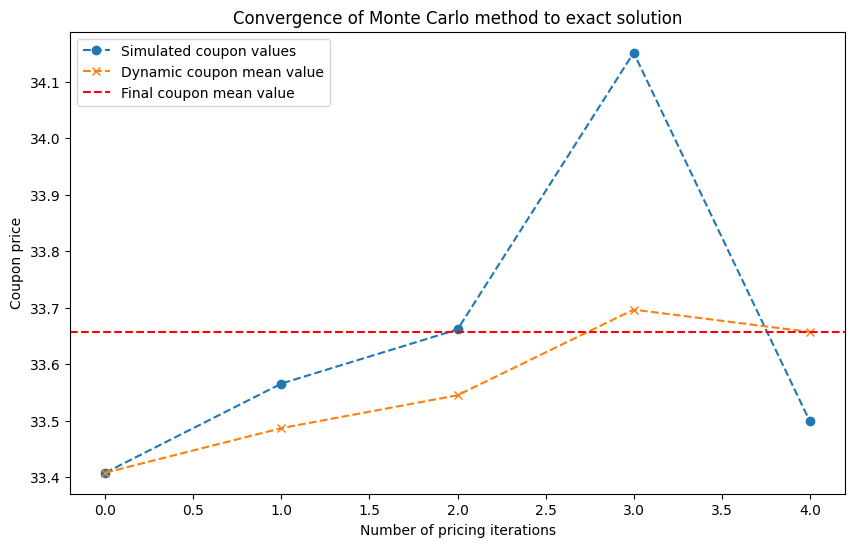

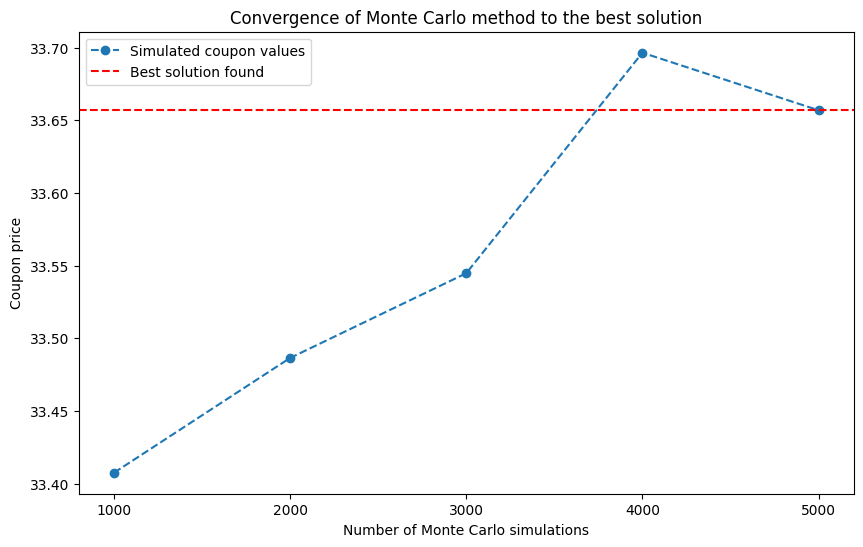

In [11]:
# parameters to price the asian option

alpha   = 1.2
daycount_Asian  = '30E/360'

# Characteristics of underlying ENEL
S_0     = 6.13
sigma   = 0.16
y_div   = 0.04

asian_coupons   = maturity_Y

# Characteristics of simulations
n_paths = 1000
num_simulations = 5
h_sigma = 1e-4
h_s     = 1e-4
coupons_total_value = 0
simulated_coupons_values = []
simulated_coupons_dynamic_mean = []
seed = 1234

coupons_total_value= get_coupons_price(S_0, y_div, sigma, asian_coupons, zeroRates_interp, monitoring_dates, n_paths, h_sigma, num_simulations, alpha, daycount_Asian)

33.24143374685669


Text(0.5, 1.0, 'Simulated prices for 4 years')

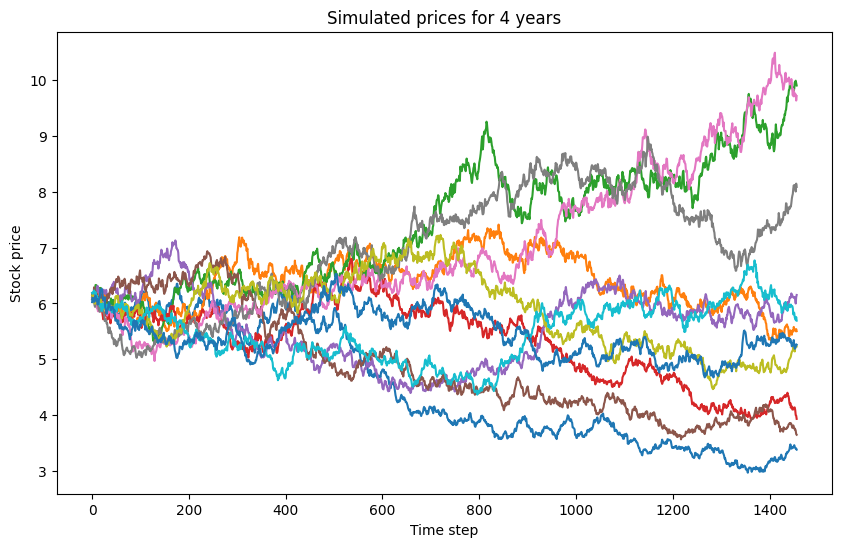

In [12]:
# From the analisys we determine that achieve convergence with 500 simulations 
## We plot the paths of the stock of the first 12 paths calculated

def asian_npv_price(S_0, y_div, sigma, asian_coupons, zeroRates_interp, monitoring_dates, n_paths, h_sigma, num_simulations, alpha, daycount_Asian):
    num_simulations = 15
    _price_asian = []
    n_paths = 5000
    for j in range(num_simulations):  
        paths, trash, trash1 = exp_paths((seed+j*1000)
                                            , y_div
                                            , sigma
                                            , asian_coupons
                                            , zeroRates_interp
                                            , monitoring_dates
                                            , n_paths
                                            , h_sigma)

        NPV_asian = 100* asianOption_NPV(S_0
                                    , S_0
                                    , zeroRates_interp
                                    , monitoring_dates
                                    , paths
                                    , asian_coupons
                                    , alpha
                                    , start_date
                                    , daycount_Asian)
        
        _price_asian.append(np.sum(NPV_asian))

    price_asian = np.mean(_price_asian)
    return price_asian, paths


price_asian, paths = asian_npv_price(S_0, y_div, sigma, asian_coupons, zeroRates_interp, monitoring_dates, n_paths, h_sigma, num_simulations, alpha, daycount_Asian)
print(price_asian)

plt.figure(figsize=(10,6))
plt.plot(S_0*paths[1:12,:].transpose())
plt.xlabel('Time step')
plt.ylabel('Stock price')
plt.title('Simulated prices for {} years'.format(4))

In [13]:
print("The total value of the coupons paid by the I.B is ",f'{(price_asian):2f}', "MIO EUR")

The total value of the coupons paid by the I.B is  33.241434 MIO EUR


### 4. Upfront Pricing X%
We calculate the upfront by getting the difference between the net present values of the two flows of coupons and then the percentage of the face value of the bond.

In [14]:
# from the expected cash flows we derived the equation to find the upfront
upfront =  coupons_total_value*1_000_000 - p_coupon*1_000_000
upfront_x_percent = upfront/(p_Bond*1_000_000)*100
print("upfront_x_percent", f'{upfront_x_percent:1f}', "%")


upfront_x_percent 13.731166 %


### Sensitivities: Delta, Vega, DV01.
Delta, vega, and DV01 are key metrics used to measure the sensitivity of a financial instrument to various market factors. **Delta** measures the rate of change of the instrument's price with respect to the underlying asset's price. In the context of the structured bond, delta represents the change in the bond's price for a unit change in the ENEL stock price. **Vega** measures the rate of change of the instrument's price with respect to the volatility of the underlying asset. In this case, vega represents the change in the bond's price for a unit change in the ENEL stock's volatility. **DV01** measures the rate of change of the instrument's price with respect to the interest rate. In the context of the structured bond, DV01 represents the change in the bond's price for a unit change in the Euribor 3m rate.

In [15]:
## Calculate the DV01
shifted_amount = 0.0001

zeroRates_interp_shifted = zeroRates_interp + shifted_amount

coupons_total_value_shifted, paths = asian_npv_price(S_0, y_div, sigma, asian_coupons, zeroRates_interp_shifted, monitoring_dates, n_paths, h_sigma, num_simulations, alpha, daycount_Asian)
coupons_total_value, trash = asian_npv_price(S_0, y_div, sigma, asian_coupons, zeroRates_interp, monitoring_dates, n_paths, h_sigma, num_simulations, alpha, daycount_Asian)


print(f"The total value of the coupons paid by the I.B is {coupons_total_value*100} MIO EUR")
print(f"The total value of the SHIFTED coupons paid by the I.B is {coupons_total_value_shifted*100} MIO EUR")
print()

interests_shifted = get_Euribor_forward(zeroRates_interp_shifted, start_date, payment_dates, SPOL, bond_issue, daycount_Coupon)

print(f"The total value of the interests paid by the Bank XX is {p_coupon} MIO EUR")
print(f"The total value of the interests paid by the Bank XX is {interests_shifted} MIO EUR")
print()

upfront_shifted =  -interests_shifted*1_000_000 + coupons_total_value_shifted*1_000_000


#compute the price of the instruments
p_instrument = upfront + coupons_total_value*1_000_000 
p_instrument_shifted = upfront_shifted + coupons_total_value_shifted*1_000_000

print("The price of the structured bond", p_instrument/1_000_000, "MIO EUR")
print("The SHIFTED price of the structured bond", p_instrument_shifted/1_000_000, "MIO EUR")
print()

deltaP = p_instrument - p_instrument_shifted
dv01 = deltaP
print('The DV01 of the bond is ' f'{dv01:.4f}')

The total value of the coupons paid by the I.B is 3324.143374685669 MIO EUR
The total value of the SHIFTED coupons paid by the I.B is 3327.424408376569 MIO EUR

The total value of the interests paid by the Bank XX is 21.92855238603913 MIO EUR
The total value of the interests paid by the Bank XX is 21.961638238968312 MIO EUR

The price of the structured bond 44.969833777200016 MIO EUR
The SHIFTED price of the structured bond 44.586849928563055 MIO EUR

The DV01 of the bond is 382983.8486


In [16]:
# Calculation of the Delta
## By shifting the prices of the underlying by an small h we calculate the price of the option and then we estimate the option delta with the centered method
S_0_h = S_0 - h_s
S_0_H = S_0 + h_s

n_paths = 5000
iter = 10

delta = []
for i in range(iter):
    # We get the paths (exp[drift + diffusion]) 
    paths, paths_h, paths_H = exp_paths(seed 
                                    , y_div
                                    , sigma
                                    , asian_coupons
                                    , zeroRates_interp
                                    , monitoring_dates
                                    , n_paths
                                    , h_sigma)

    NPV_asian_Sh = asianOption_NPV(S_0_h
                            , S_0
                            , zeroRates_interp
                            , monitoring_dates
                            , paths
                            , asian_coupons
                            , alpha
                            , start_date
                            , daycount_Asian)

    NPV_asian_SH = asianOption_NPV(S_0_H
                            , S_0
                            , zeroRates_interp
                            , monitoring_dates
                            , paths
                            , asian_coupons
                            , alpha
                            , start_date
                            , daycount_Asian)

    # Then we calculate the price of the delta using the mid center method
    delta_i = (sum(NPV_asian_SH) - sum(NPV_asian_Sh))/(2*h_s)
    delta.append(delta_i)

delta_asian = np.average(delta)*bond_issue
print('The delta of the asian option is ' f'{delta_asian:.4f}')


The delta of the asian option is 38.6874


In [17]:
# Calculation of the Vega
## By shifting the sigma of the underlying by an small h we calculate the price of the option and then we estimate the option vega with the centered method

iter = 10
n_paths = 5000

vega = []
for i in range(iter):
    # We get the paths (exp[drift + diffusion]) 
    paths, paths_h, paths_H = exp_paths(seed 
                                    , y_div
                                    , sigma
                                    , asian_coupons
                                    , zeroRates_interp
                                    , monitoring_dates
                                    , n_paths
                                    , h_sigma)
    NPV_asian_sigmah = asianOption_NPV(S_0
                                    , S_0
                                    , zeroRates_interp
                                    , monitoring_dates
                                    , paths_h
                                    , asian_coupons
                                    , alpha
                                    , start_date
                                    , daycount_Asian)

    NPV_asian_sigmaH = asianOption_NPV(S_0
                                    , S_0
                                    , zeroRates_interp
                                    , monitoring_dates
                                    , paths_H
                                    , asian_coupons
                                    , alpha
                                    , start_date
                                    , daycount_Asian)
    # Then we calculate the price of the vega using the mid center method
    vega_i = (sum(NPV_asian_sigmaH) - sum(NPV_asian_sigmah))/(2*h_s)
    vega.append(vega_i)

vega_asian = np.average(vega)*bond_issue
print('The vega of the asian option is ' f'{vega_asian:.4f}')

The vega of the asian option is 208.5162


In [18]:
print(f"Delta: " f'{delta_asian:.4f}')
print(f"Vega: " f'{vega_asian:.4f}')
print(f"DV01: " f'{dv01:.4f}')

Delta: 38.6874
Vega: 208.5162
DV01: 382983.8486


### Hedging
Hedging the Delta, Vega, and DV01 of the structured bond involves managing the sensitivities of the portfolio to changes in the underlying asset's price, volatility, and interest rates, respectively. Delta measures the change in the portfolio's value due to changes in the price of the ENEL stock. To hedge Delta, we calculate the portfolio's Delta and hold an equivalent amount of ENEL stock in the opposite direction. Vega measures the sensitivity to changes in the volatility of the ENEL stock. To hedge Vega, we compute the portfolio's Vega and use options, such as a 4-year ATM European call on ENEL, to offset this exposure by purchasing or selling an appropriate number of options. DV01 measures the change in the portfolio's value for a 1 basis point change in interest rates. To hedge DV01, we enter into a 4-year interest rate swap with a notional amount such that the swap's DV01 offsets the portfolio's DV01. By solving the system of equations representing these sensitivities, we determine the precise quantities of ENEL stock, European call options, and interest rate swaps required to achieve a hedged position, thereby neutralizing the portfolio's exposure to price, volatility, and interest rate changes.

In [19]:
#linear system solution

# Given values
S_0 = 6.13  # ENEL stock price
K = 6.13  # ATM forward little less than s0
T = 4  # 4 years to maturity
sigma = 0.16  # Volatility 16%

monitoring_date_last    = monitoring_dates[asian_coupons-1]
zeroRates_AsianFilter   = zeroRates_interp[zeroRates_interp.index <= monitoring_date_last]
r = (np.sum(zeroRates_AsianFilter['zero_Rate']))/zeroRates_AsianFilter.size
#print(r)

# Calculate d1
d1 = (np.log(S_0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

# Calculate Vega
vega_call = S_0 * np.sqrt(T) * norm.pdf(d1)
#print(f"Vega of one call option: {vega_call}")

# Number of calls required for Vega hedging
number_of_calls = vega / vega_call
#print(f"Number of European call options required: {number_of_calls}")

#############


# compute a call on the stock enel
# Function to compute d1
def d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

# Function to compute the delta of a call option
def call_delta(S, K, T, r, sigma):
    d1_value = d1(S, K, T, r, sigma)
    delta = norm.cdf(d1_value)
    return delta


# Compute the delta of the call option
delta_call = call_delta(S_0, K, T, r, sigma)

#print(f"Delta of the European call option on the ENEL stock: {delta_call}")

# Define the coefficients of the linear system
coefficients = np.array([
    [1, delta_call],  # Delta of stock is 1
    [0, vega_call]    # Vega of stock is 0
])

# Define the values we want to achieve (hedged portfolio with zero delta and vega)
values = np.array([
    -delta_asian,  # Opposite of the delta
    -vega_asian    # Opposite of the vega
])

# Solve the linear system to find the hedge quantities
hedge_quantities = np.linalg.solve(coefficients, values)

# Output the hedge quantities
num_stocks, num_calls = hedge_quantities
print(f"Number of ENEL stocks needed to hedge Delta second method: " f'{num_stocks*100:.2f}' " Milions")
print(f"Number of 4-year ATM European call options needed to hedge Vega second method: " f'{num_calls*100:.2f}' " Milions")



Number of ENEL stocks needed to hedge Delta second method: 28.75 Milions
Number of 4-year ATM European call options needed to hedge Vega second method: -5257.39 Milions


### Interest Rate swap 4y

To hedge the EURIBOR bond using a IR SWAP we calculate the forward interest rate using:
$$
S_{0} = \frac{1-B(0,T_{M+1})}{\delta \sum ^{M+1}_{i=1}B(0,T_{i})}
$$
Finally the price of the SWAP will be:
$$
NominalAmount \cdot S_{0} \delta \sum ^{M+1}_{i=1} B(0,T_{i})
$$

In [20]:
# Bringing the dates of the EURIBOR + 3m and the discount values

coupons = maturity_Y * 4
delta_c = 1/4
t_coupon= 360/4
daycount_SWAP = '30E/360'


# Getting the LIBOR forward + SPOL
discount_SWAP    = []
for i in range(coupons):
    T           = payment_dates[i]
    zid_T       = zeroRates_interp.index.get_loc(T)
    
    # Discount at time T
    zRate_T     = zeroRates_interp.iloc[zid_T]['zero_Rate']
    yFrac_T     = yearfrac(start_date, T, daycount_SWAP)
    B_z         = np.exp(-zRate_T*yFrac_T)
    discount_SWAP.append(B_z)
    
SWAP_rate   = (1-discount_SWAP[-1])/delta_c/np.sum(discount_SWAP)

# To hedge against the amount we have to buy the following amount

SWAP_hedge = p_Bond*SWAP_rate*delta_c*np.sum(discount_SWAP)

print("To hedege on the IR we have to buy the following amount of SWAP " f'{SWAP_hedge:2f}' 'MMEUR')

To hedege on the IR we have to buy the following amount of SWAP 12.292768MMEUR
